In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [2]:
import numpy as np
def convert_to_one_hot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)].T
    
    return Y

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]           
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
import pandas as pd
data1 = pd.read_csv('datasets/train.csv')
data2 = pd.read_csv('datasets/test.csv')
data1 = np.array(data1)
data2 = np.array(data2)
X_train = data1[:,1::]/255
X_test = data2[:,:]/255
n1 = X_train.shape[0]
n2 = X_test.shape[0]
X_train = np.reshape(X_train,(n1,28,28,1))
X_test = np.reshape(X_test,(n2,28,28,1))
X_train = np.pad(X_train,((0,0),(2,2),(2,2),(0,0)),'constant')
Y_train = data1[:,np.newaxis,0]
X_test = np.pad(X_test,((0,0),(2,2),(2,2),(0,0)),'constant')
Y_train = convert_to_one_hot(Y_train,10).T
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(42000, 32, 32, 1)
(42000, 10)
(28000, 32, 32, 1)


In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(dtype = tf.float32,shape=[None,n_H0,n_W0,n_C0],name="X")
    Y = tf.placeholder(dtype=tf.float32,shape=[None,n_y],name="Y")
    
    return X, Y

In [6]:
def initialize_parameters():
    
    tf.set_random_seed(1)                            
    
    W1 = tf.get_variable(name="W1",shape=[5,5,1,6],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable(name="W2",shape=[5,5,6,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable(name="W3",shape=[120,400],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b3 = tf.get_variable(name="b3",shape=[120,1],initializer=tf.zeros_initializer())
    W4 = tf.get_variable(name="W4",shape=[84,120],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b4 = tf.get_variable(name="b4",shape=[84,1],initializer=tf.zeros_initializer())
    W5 = tf.get_variable(name="W5",shape=[10,84],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b5 = tf.get_variable(name="b5",shape=[10,1],initializer=tf.zeros_initializer())

    parameters = {"W1": W1,"W2": W2,"W3":W3,"b3":b3,"W4":W4,"b4":b4,"W5":W5,"b5":b5}
    
    return parameters

In [7]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="VALID")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,[1,2,2,1],[1,2,2,1],"VALID")
    Z2 = tf.nn.conv2d(P1,W2,[1,1,1,1],"VALID")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,[1,2,2,1],[1,2,2,1],"VALID")
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.add(tf.matmul(W3,tf.transpose(P2)),b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4,A3),b4)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.add(tf.matmul(W5,A4),b5)

    return tf.transpose(Z5)

In [8]:
def compute_cost(Z5, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z5,labels=Y))
    
    return cost

In [9]:
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

In [10]:
def model(X_train, Y_train,X_test, learning_rate = 0.009,
          num_epochs = 15, minibatch_size = 256, print_cost = True):

    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y = create_placeholders(n_H0,n_W0,n_C0,n_y)

    parameters = initialize_parameters()
    
    Z5 = forward_propagation(X,parameters)
    
    y_hat = tf.argmax(Z5,1)
    yy = tf.argmax(Y_train,1)
    correct_pred = tf.equal(y_hat,yy)
    cnt = tf_count(correct_pred, True)
    
    cost = compute_cost(Z5,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        y_test = forward_propagation(X,parameters)
        y1 = tf.argmax(y_test,1)
        a=str(sess.run(cnt,feed_dict={X:X_train}))
        y_tst=tf.Session().run(y1,feed_dict={X : X_test})
        
        return a,y_tst,parameters

Cost after epoch 0: 0.219671
Cost after epoch 5: 0.027186
Cost after epoch 10: 0.025502


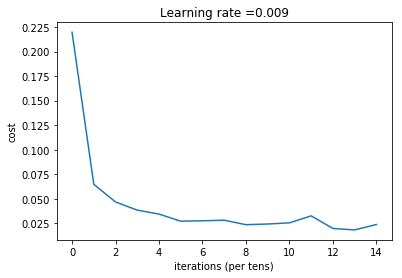

Parameters have been trained!


In [11]:
a,y_tst,parameters = model(X_train, Y_train,X_test)

In [12]:
train_acc = (int(a)/n1)*100
print(train_acc)

98.94285714285715


In [13]:
y_tst=y_tst.reshape(28000,1)

In [14]:
c = np.array([[i+1 for i in range(28000)]]).T

In [15]:
ans=np.concatenate((c,y_tst),axis=1)

In [423]:
np.savetxt("ans.csv", ans,"%s", delimiter=",")